In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn.impute import SimpleImputer

import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, BatchNormalization

from imblearn.keras import BalancedBatchGenerator


## Part 2: Supervised Learning Model

In [2]:
mailout_train = pd.read_csv('data/Udacity_MAILOUT_052018_TRAIN.csv', sep=';')

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [159]:
mailout_train.shape

(42962, 367)

In [3]:
y = mailout_train.RESPONSE
X = mailout_train.drop('RESPONSE', axis=1)

In [161]:
y.value_counts()

0    42430
1      532
Name: RESPONSE, dtype: int64

### Get to know the data

In [4]:
# Load feature info
feat_info = pd.read_csv('features.csv')
feat_info.set_index('attribute', inplace=True)

# Parse missing_or_known string into a list
def parse_missing(s):
    a = s[1:-1].split(',')
    return a

feat_info['missing_or_unknown'] = feat_info['missing_or_unknown'].apply(parse_missing)

In [187]:
X_clean = X

# Drop columns not in data dictionary
missing_from_feat_info = set(X_clean.columns.values).difference(feat_info.index.values)
X_clean.drop(list(missing_from_feat_info), axis='columns', inplace=True)

# Convert missing values to Nans
missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.index).to_dict()
X_clean[X_clean.isin(missing_values)] = np.nan

In [164]:
X_clean.shape

(42962, 327)

In [188]:
# Missing values by column
p_missing = (X_clean.isnull().sum() / X_clean.shape[0])
p_missing.sort_values(ascending=False).head(20)

TITEL_KZ          0.995042
KK_KUNDENTYP      0.589265
KBA05_BAUMAX      0.534891
AGER_TYP          0.439691
GEBURTSJAHR       0.406755
ALTER_HH          0.306713
W_KEIT_KIND_HH    0.242470
REGIOTYP          0.231134
KKK               0.231134
HH_DELTA_FLAG     0.225269
KBA05_KRSKLEIN    0.210209
KBA05_MOD4        0.210209
KBA05_MOD3        0.210209
KBA05_MOD2        0.210209
KBA05_MOD1        0.210209
KBA05_MAXSEG      0.210209
KBA05_MAXHERST    0.210209
KBA05_MAXBJ       0.210209
KBA05_MAXAH       0.210209
KBA05_KW3         0.210209
dtype: float64

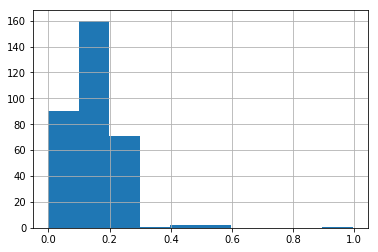

In [166]:
p_missing.hist();

In [185]:
to_drop = p_missing[p_missing >= .22]
to_drop.index

Index(['AGER_TYP', 'ALTER_HH', 'GEBURTSJAHR', 'HH_DELTA_FLAG', 'KBA05_BAUMAX',
       'KK_KUNDENTYP', 'KKK', 'REGIOTYP', 'TITEL_KZ', 'W_KEIT_KIND_HH'],
      dtype='object')

In [168]:
X_clean = X_clean.drop(to_drop.index, axis=1)
X_clean.shape

(42962, 317)

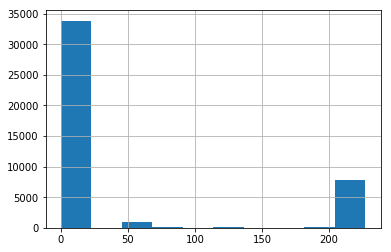

In [169]:
# Missing values by row
n_missing = X_clean.isnull().sum(axis=1)
n_missing.hist();

In [170]:
X_clean['RESPONSE'] = y

In [171]:
above_yes = X_clean[(n_missing > 10) & (X_clean.RESPONSE == 1)]
above_yes.shape

(116, 318)

Keep all rows because we would lose too many response=1.

### Clean Data 

In [9]:
def clean_data(df, feat_info, row_threshold):
    clean_df = df.copy()
    
    # Drop unwanted columns    
    missing_from_feat_info = set(clean_df.columns.values).difference(feat_info.index.values)
    clean_df.drop(list(missing_from_feat_info), axis='columns', inplace=True)
    
    # Convert missing values to Nans
    missing_values = pd.Series(feat_info['missing_or_unknown'].values, index=feat_info.index).to_dict()
    clean_df[clean_df.isin(missing_values)] = np.nan
    
    # Drop columns with missing values
    to_drop = ['AGER_TYP', 
               'ALTER_HH', 
               'GEBURTSJAHR', 
               'HH_DELTA_FLAG', 
               'KBA05_BAUMAX',
               'KK_KUNDENTYP', 
               'KKK', 
               'REGIOTYP', 
               'TITEL_KZ', 
               'W_KEIT_KIND_HH']
    clean_df = clean_df.drop(to_drop, axis='columns')

    # Don't drop KBA columns
    
    # Drop rows with missing values
    missing_by_row = clean_df.isnull().sum(axis=1)

    dropped_df = clean_df[missing_by_row > row_threshold]
    clean_df = clean_df[missing_by_row <= row_threshold]
    
    # Feature Re-encoding and Engineering
    # Recode 10's to 0 for D19 columns that need it
    recode = ['D19_BANKEN_DATUM', 'D19_BANKEN_OFFLINE_DATUM',
       'D19_BANKEN_ONLINE_DATUM', 'D19_GESAMT_DATUM',
       'D19_GESAMT_OFFLINE_DATUM', 'D19_GESAMT_ONLINE_DATUM',
       'D19_TELKO_DATUM', 'D19_TELKO_OFFLINE_DATUM',
       'D19_TELKO_ONLINE_DATUM', 'D19_VERSAND_DATUM',
       'D19_VERSAND_OFFLINE_DATUM', 'D19_VERSAND_ONLINE_DATUM',
       'D19_VERSI_DATUM', 'D19_VERSI_OFFLINE_DATUM',
       'D19_VERSI_ONLINE_DATUM']
    clean_df[recode] = clean_df[recode].replace(10, 0)
    
    # Drop all fine scale variables in favor of the rough scale version
    drop = ['CAMEO_DEU_2015', 'LP_FAMILIE_FEIN', 'LP_STATUS_FEIN']
    clean_df.drop(drop, axis=1, inplace=True)
    
    # convert CAMEO_DEUG_2015 from string to float
    clean_df['CAMEO_DEUG_2015'] = clean_df['CAMEO_DEUG_2015'].astype(float)
    
    # Re-encode categorical variable(s) to be kept in the analysis
    recoded = pd.get_dummies(clean_df['OST_WEST_KZ'])
    clean_df.drop('OST_WEST_KZ', axis=1, inplace=True)
    clean_df = pd.concat([clean_df, recoded], axis=1)

    # Engineer new variables
    to_replace = {1:40, 2:40, 3:50, 4:50, 5:60, 6:60, 7:60, 8:70, 9:70, 10:80, 11:80, 12:80, 13:80, 14:90, 15:90}
    clean_df['decade'] = clean_df['PRAEGENDE_JUGENDJAHRE'].replace(to_replace)

    to_replace = {1:0, 2:1, 3:0, 4:1, 5:0, 6:1, 7:1, 8:0, 9:1, 10:0, 11:1, 12:0, 13:1, 14:0, 15:1}
    clean_df['movement'] = clean_df['PRAEGENDE_JUGENDJAHRE'].replace(to_replace)    

    clean_df['wealth'] = clean_df.CAMEO_INTL_2015[clean_df.CAMEO_INTL_2015.notnull()].map(lambda x: int(str(x)[0]))
    clean_df['life_stage'] = clean_df.CAMEO_INTL_2015[clean_df.CAMEO_INTL_2015.notnull()].map(lambda x: int(str(x)[1]))
    
    # Drop unneeded variables
    clean_df.drop(['PRAEGENDE_JUGENDJAHRE', 'CAMEO_INTL_2015',
                   'LP_LEBENSPHASE_GROB', 'LP_LEBENSPHASE_FEIN'], axis=1, inplace=True)

    # Return the cleaned dataframe and dropped rows.
    return clean_df, dropped_df

In [10]:
X_clean, X_dropped = clean_data(X, feat_info, row_threshold=len(mailout_train.columns))
print(X_clean.shape)
print(X_dropped.shape)

(42962, 315)
(0, 317)


### Preprocess

In [198]:
numeric = feat_info[feat_info.type == 'numeric'].index.drop(['GEBURTSJAHR','KBA13_ANZAHL_PKW'])
numeric

Index(['ANZ_HAUSHALTE_AKTIV', 'ANZ_HH_TITEL', 'ANZ_KINDER', 'ANZ_PERSONEN',
       'ANZ_STATISTISCHE_HAUSHALTE', 'ANZ_TITEL', 'MIN_GEBAEUDEJAHR'],
      dtype='object', name='attribute')

In [85]:
X_clean.iloc[:5, 6]

0    3.0
1    2.0
2    4.0
3    4.0
4    3.0
Name: ARBEIT, dtype: float64

In [11]:
numerical_columns = feat_info[feat_info.type == 'numeric'].index.drop(['GEBURTSJAHR','KBA13_ANZAHL_PKW'])
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler())

categorical_columns = X_clean.columns.drop(numerical_columns)
categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'))

preprocessor = ColumnTransformer(
    [('numerical_preprocessing', numerical_pipeline, numerical_columns),
     ('categorical_preprocessing', categorical_pipeline, categorical_columns)],
    remainder='drop')

In [12]:
X_clean.dtypes.value_counts()

float64    231
int64       82
uint8        2
dtype: int64

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_clean, y, test_size=0.2, random_state=42, stratify=y)

X_train = preprocessor.fit_transform(X_train)
print(X_train.shape)

X_test = preprocessor.transform(X_test)

(34369, 315)


### Model

In [21]:
def make_model(n_features):
    model = Sequential()
    model.add(Dense(50, input_shape=(n_features,),
              kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.15))
    model.add(Dense(25, kernel_initializer='glorot_normal'))
    model.add(Activation('relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(loss='binary_crossentropy',
                  optimizer=keras.optimizers.Adam(lr=.001),
                  metrics=['acc'])

    return model

In [22]:
def fit_predict_balanced_model(X_train, y_train):
    model = make_model(X_train.shape[1])
    training_generator = BalancedBatchGenerator(X_train, y_train)
    model.fit_generator(generator=training_generator, epochs=100, verbose=False)
    return model

In [23]:
model = fit_predict_balanced_model(X_train, y_train)
y_pred = model.predict_proba(X_test)
roc_auc = roc_auc_score(y_test, y_pred)
roc_auc

0.5974737167388081

0.7421339184679788

### Hyperparameter Estimation

## Part 3: Kaggle Competition

In [52]:
mailout_test = pd.read_csv('data/Udacity_MAILOUT_052018_TEST.csv', sep=';')

C:\Users\Mei\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [53]:
mailout_test.shape

(42833, 366)

In [55]:
LNR = mailout_test.LNR
LNR.head()

0    1754
1    1770
2    1465
3    1470
4    1478
Name: LNR, dtype: int64

In [183]:
mailout_test, mailout_test_dropped = clean_data(mailout_test, feat_info, row_threshold=len(mailout_test))
mailout_test = preprocessor.transform(mailout_test)
#test_pred = model.predict_proba(mailout_test)
test_pred = model.predict_proba(mailout_test)
test_pred[0:5]

AttributeError: 'numpy.ndarray' object has no attribute 'columns'

In [71]:
pred = test_pred.flatten()
pred = pd.Series(np.where(pred > .5, 1, 0))
pred.head()

0    1
1    1
2    1
3    0
4    0
dtype: int32

In [79]:
submission = pd.DataFrame({'LNR':LNR, 'RESPONSE':pred})
submission.shape

(42833, 2)

In [78]:
submission.to_csv('pred1.csv', index=False)